In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((517, 12, 1), (517,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 21s 247ms/step - loss: 0.2700 - root_mean_squared_error: 0.5196 - val_loss: 0.2085 - val_root_mean_squared_error: 0.4566
Epoch 2/50
53/53 [==============================] - 16s 303ms/step - loss: 0.1926 - root_mean_squared_error: 0.4389 - val_loss: 0.1133 - val_root_mean_squared_error: 0.3366
Epoch 3/50
53/53 [==============================] - 16s 304ms/step - loss: 0.1240 - root_mean_squared_error: 0.3521 - val_loss: 0.1014 - val_root_mean_squared_error: 0.3184
Epoch 4/50
53/53 [==============================] - 12s 233ms/step - loss: 0.1092 - root_mean_squared_error: 0.3305 - val_loss: 0.0905 - val_root_mean_squared_error: 0.3008
Epoch 5/50
53/53 [==============================] - 11s 214ms/step - loss: 0.0937 - root_mean_squared_error: 0.3061 - val_loss: 0.0767 - val_root_mean_squared_error: 0.2769
Epoch 6/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0724 - root_mean_squared_error: 0.2690 - val_loss: 0.0456 

Epoch 37/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 38/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0825
Epoch 39/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1084
Epoch 40/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715
Epoch 41/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0054 - root_mean_squared_error: 0.0734 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 42/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0087 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.811845803260803 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

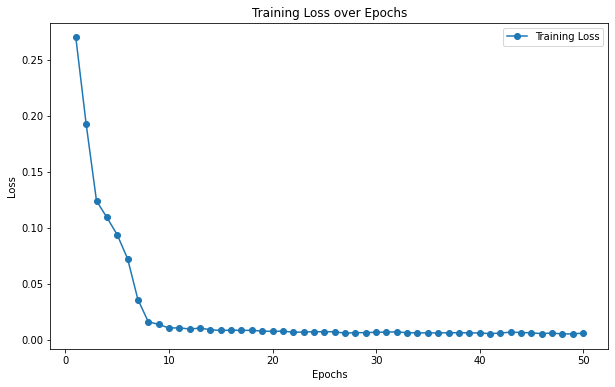

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

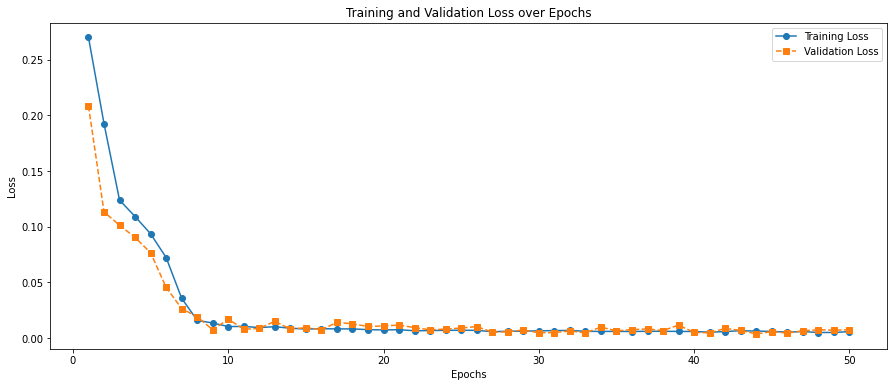

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 11ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.05259699756864819
MAE : 0.04142805143573144


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.672359e+05,346601.304
1,2.114268e+05,444914.605
2,4.905627e+05,827036.916
3,1.053813e+06,1142021.216
4,1.788693e+06,1885693.654
5,2.595186e+06,2542569.663
6,3.241398e+06,3107373.845
7,3.578284e+06,3488175.444
8,3.719730e+06,3746306.528
9,3.266003e+06,2942322.822


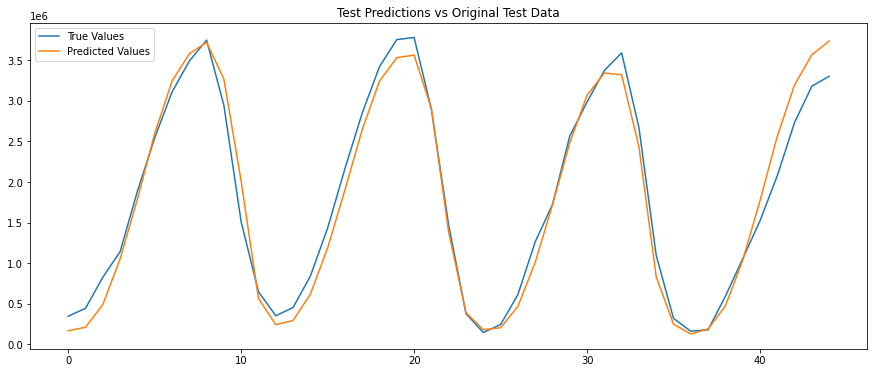

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

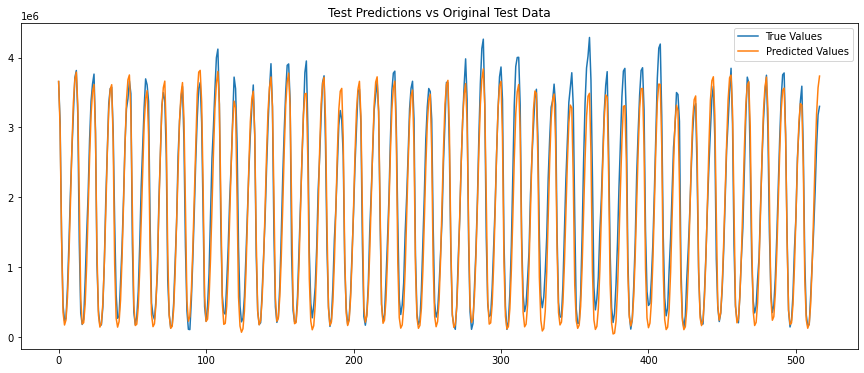

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()